In [1]:
import numpy as np
import math

In [2]:
def norm(x):
    return np.sqrt(np.sum(x**2))

def dist(x, y):
    return norm(x-y)

In [3]:
def Nesterov(x):
    n = len(x)
    f = (x[0]-1)**2/4
    for i in range(1,n):
        f += (x[i] - 2*x[i-1]**2 + 1)**2
    return f

def grad_Nesterov(x):
    n = len(x)
    g = np.zeros(n)
    g[0] = (x[0]-1)/2 - 8*x[0]*(x[1] - 2*x[0]**2 + 1)
    for i in range(1,n-1):
        g[i] = 2*(x[i] - 2*x[i-1]**2 + 1) - 8*x[i]*(x[i+1] - 2*x[i]**2 + 1)
    g[n-1] = 2*(x[n-1] - 2*x[n-2]**2 + 1)
    return g

In [69]:
x = np.arange(1,10)
h = 0.0001
print(grad_Nesterov(x))
gr = np.zeros(len(x))
for i in range(0, len(x)):
    ni = np.zeros(len(x))
    ni[i] = h
    gr[i] = (Nesterov(x+ni) - Nesterov(x))/h
print(gr)

[  -8.   66.  304.  806. 1668. 2986. 4856. 7374. -236.]
[  -8.     66.01  304.02  806.04 1668.06 2986.08 4856.11 7374.15 -236.  ]


In [4]:
def OGMG(x0, L, N, f, g):
    Theta = np.ones(N+1)
    for i in range(N-1,0,-1):
        Theta[i] = (1+np.sqrt(1+4*Theta[i+1]**2))/2
    Theta[0] = (1+np.sqrt(1+8*Theta[1]**2))/2
    
    beta = np.zeros(N)
    gamma = np.zeros(N)
    
    x = np.zeros((N+1, len(x0)))
    y = np.zeros((N+1, len(x0)))
    
    x[0] = x0
    y[0] = x0
    
    for i in range(0,N):
        gamma[i] = (2*Theta[i+1]-1)/(2*Theta[i]-1)
        beta[i] = gamma[i]*(Theta[i]-1)/Theta[i]
        y[i+1] = x[i] - g(x[i])/L
        x[i+1] = y[i+1] + beta[i]*(y[i+1]-y[i]) + gamma[i]*(y[i+1]-x[i])
    
    return x[-1]

In [74]:
xx = -0.5*np.ones(55)
x[0] = 0.5
grad_Nesterov(x)

array([-5.00e-01,  7.00e+01,  3.04e+02,  8.06e+02,  1.67e+03,  2.99e+03,
        4.86e+03,  7.37e+03, -2.36e+02])

In [5]:
n = 1000
x0 = np.ones(n)
x_ = np.zeros(n)
Ls = [0.5, 0.9, 1, 1.1, 1.5, 2, 10, 20]
Ns = [int(n/10), int(n/2), n, n*5, n*20]
results = []
for L in Ls:
    L_results = []
    for N in Ns:
        traect = OGMG(x0, L, N, lambda x: np.sum(x**2)/2, lambda x: x)
        dists = []
        for x in traect:
            dists.append(dist(x, x_))
        L_results.append((N, dists))
    results.append(L_results)

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in true_divide
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in subtract
C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in add


In [6]:
A = np.diag(np.arange(1,11)**3)

In [7]:
def f(x):
    return np.dot(x, np.dot(A, x))/2

def g(x):
    return np.dot(A, x)

In [45]:
n = 10
x0 = np.arange(1,n+1)
x_ = np.zeros(n)
L = 1000
mu = 30

x = OGMG(x0, L, math.ceil(2*np.sqrt(2*L/mu)), f, g)
print(dist(g(x0), 0))
print(dist(g(x), 0))
print(x)

12951.11319539753
712.8167549103867
[ 9.05e-01  8.07e-01 -2.51e-01 -2.75e-02  3.95e-02 -4.44e-03 -4.84e-03
 -1.48e-04  2.22e-06 -7.13e-01]


In [46]:
def OGMG_count(x0, L, mu, g, eps):
    x = x0
    G = norm(g(x))
    Nop = 0
    while G > eps:
        N = math.ceil(2*np.sqrt(2*L/mu))
        x_new = OGMG(x, L, N, f, g)
        Nop += N
        x = x_new
        G = norm(g(x))
    return Nop, x

In [47]:
def OGMG_adapt(x0, L, mu, g, eps):
    x = x0
    G = norm(g(x))
    Nop = 0
    CH = True
    while G > eps:
        if CH:
            mu *= 2
        else:
            CH = True
        N = math.ceil(2*np.sqrt(2*L/mu))
        x_new = OGMG(x, L, N, f, g)
        Nop += N
        if norm(g(x_new)) <= G*0.5:
            x = x_new
            G = norm(g(x))
        elif norm(g(x_new)) <= G:
            x = x_new
            G = norm(g(x))
            mu /= 2
            CH = False
        else:
            mu /= 2
            CH = False
    return Nop, x

In [79]:
y = OGMG_count(np.zeros(15), L, mu*10000, grad_Nesterov, 0.00001)
print(y)
print(norm(grad_Nesterov(y[1])))

KeyboardInterrupt: 

In [ ]:
y = OGMG_adapt(np.zeros(15), L, mu*10000, grad_Nesterov, 0.00001)
print(y)
print(norm(grad_Nesterov(y[1])))

In [54]:
MU = 10.0**(np.arange(0,12)-2)
GF_E = np.arange(1,11)
simple = np.zeros((12,10))
adapt = np.zeros((12,10))
for i in range(0, 12):
    for j in range(0, 10):
        simple[i][j] = OGMG_count(x0, L, MU[i], g, norm(g(x0))/(10**GF_E[j]))[0]
        adapt[i][j] = OGMG_adapt(x0, L, MU[i], g, norm(g(x0))/(10**GF_E[j]))[0]
        print(i,j)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9


In [55]:
np.set_printoptions(precision=2)
print(simple/adapt)

[[ 1.41  1.41  1.66  1.66  1.66  1.92  1.92  1.66  2.21  2.21]
 [ 1.42  1.42  1.65  1.65  1.92  1.92  1.65  2.01  1.89  1.89]
 [ 1.41  1.65  1.65  1.91  1.65  1.05  0.79  0.8   0.67  0.67]
 [ 1.45  1.66  1.93  1.32  0.98  1.32  1.37  1.48  1.52  1.56]
 [ 0.75  1.69  1.09  0.97  2.15  2.98  3.16  3.27  3.33  3.43]
 [ 1.5   1.2   1.18  1.59  3.51  5.38  6.43  7.11  7.58  7.82]
 [ 1.    1.    1.62  2.67  5.85  7.76  8.36  9.48  9.75  9.34]
 [ 1.    1.    1.3   2.52  5.77  7.    7.48  8.31  8.73  8.62]
 [ 1.    0.92  1.3   2.29  5.14  7.7   9.1   9.97 10.58 10.9 ]
 [ 1.    1.    1.33  2.46  5.67  7.62  8.25  9.38  9.66  9.26]
 [ 1.    1.    1.3   2.36  5.12  7.12  7.57  8.39  8.8   8.69]
 [ 1.    1.    1.27  2.46  4.66  6.41  7.24  7.73  7.77  7.64]]


In [58]:
print(adapt)

[[ 633.  633. 1081. 1081. 1081. 1398. 1398. 1622. 1622. 1622.]
 [ 200.  200.  342.  342.  442.  442.  513.  563.  599.  599.]
 [  64.  109.  109.  141.  164.  344.  453.  562.  671.  671.]
 [  20.   35.   45.   66.  237.  374.  528.  665.  819.  819.]
 [  12.   16.   33.   93.  260.  398.  572.  746.  920.  920.]
 [   4.   10.   33.  104.  285.  395.  505.  615.  725.  725.]
 [   4.   11.   32.   84.  233.  373.  530.  629.  769.  827.]
 [   4.   11.   40.   89.  236.  414.  592.  718.  859.  896.]
 [   4.   12.   40.   98.  265.  376.  487.  598.  709.  709.]
 [   4.   11.   39.   91.  240.  380.  537.  636.  776.  834.]
 [   4.   11.   40.   95.  266.  407.  585.  711.  852.  889.]
 [   4.   11.   41.   91.  292.  452.  612.  772.  965. 1012.]]


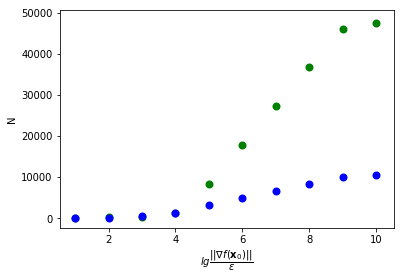

In [17]:
import matplotlib.pylab as plt
%matplotlib inline

i = 4

for k in range(0, 10):
    plt.scatter(GF_E[k], simple[i][k], lw=2, color = 'green')#, alpha = 1)
    plt.scatter(GF_E[k], adapt[i][k], lw=2, color = 'blue')#, alpha = 1)
    plt.xlabel(r'$lg\dfrac{||\nabla f({\bf x}_0)||}{\varepsilon}$')
    plt.ylabel('N')

In [147]:
x0

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [21]:
A = np.diag(np.arange(1,1001)**2)
np.dot(x0, np.dot(A, x0))

333833500.0

0.5 100
10 46957359.11201222
11 196194871.76306945
12 819607812.894055
13 3423399017.4685745
14 14296852645.55637
15 59697107625.39193
16 249226636238.02267
17 1040308798359.2598
18 4341651991191.467
19 18116357409538.3
20 75580198830901.36
21 315256853974949.75
22 1314735556469444.5
23 5481855393313579.0
24 2.2852298595920736e+16
25 9.52452055699115e+16
26 3.968852492576126e+17
27 1.6534573039173284e+18
28 6.886914608684378e+18
29 2.8678569859519468e+19
30 1.1939568886676932e+20
31 4.969530215070681e+20
32 2.0679241773538953e+21


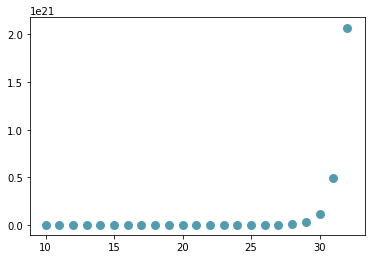

In [154]:
import matplotlib.pylab as plt
%matplotlib inline


#_, ax = plt.subplots()
print(Ls[0], Ns[0])
N = results[0][0][0]
for k in range(int(N/10), int(N/3)):
    print(k, results[0][0][1][k])
    plt.scatter(k, results[0][0][1][k], lw=3, color = '#539caf', alpha = 1)



In [85]:
np.eye(5)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])